# Pryngles module: Plotting

In [1]:
from pryngles import *

## External modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from colorsys import hls_to_rgb
import rebound as rb
from tqdm import tqdm

#Plotting in 3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation

## The Plot Utilities

In [3]:
class Plot(object):
    
    def _pathpatch_2d_to_3d(pathpatch,pivot=[0,0,0],zDir=[0,0,1]):
        """
        Create a patch in 3d around pivot in the direction of zDir
        
        Source: https://stackoverflow.com/a/69785236
        """

        path = pathpatch.get_path() #Get the path and the associated transform
        trans = pathpatch.get_patch_transform()
        path = trans.transform_path(path) #Apply the transform

        pathpatch.__class__ =  mplot3d.art3d.PathPatch3D #Change the class
        pathpatch._path2d = path       #Copy the 2d path
        pathpatch._code3d = path.codes #Copy the codes
        pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color

        # Get the 2D vertices and add the third dimension
        verts3d = np.empty((path.vertices.shape[0],3))
        verts3d[:,0:2] = path.vertices
        verts3d[:,2] = pivot[2]

        #Get rotation matriz
        norm = np.linalg.norm(zDir)
        zDir = zDir/norm
        if np.abs(zDir[2])==1:
            yDir = np.array([0,zDir[2],0])
        else:
            yDir = (np.array([0,0,1]) - zDir[2]*zDir)/math.sqrt(1-zDir[2]**2)
        rotMat = np.empty((3,3))
        rotMat[:,0] = np.cross(zDir,yDir)
        rotMat[:,1] = yDir
        rotMat[:,2] = -zDir
        R=Rotation.from_matrix(rotMat)

        #Displace
        pathpatch._segment3d = R.apply(verts3d - pivot) + pivot

        return pathpatch

    # places a 3D circle in axes with 3d projection. 
    def circle3d(ax, center = (0,0,0), radius = 1, zDir='z', **kwargs):
        """
        Add a circle in 3d
        """
        pc = Circle(center[0:2], radius, **kwargs)
        ax.add_patch(Plot._pathpatch_2d_to_3d(pc, center, zDir))
        
    def pryngles_mark(ax):
        """Add a water mark to a 2d or 3d plot.
        
        Parameters:
        
            ax: Class axes: 
                Axe where the pryngles mark will be placed.
        """
        #Get the height of axe
        axh=ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted()).height
        fig_factor=axh/4
        
        #Options of the water mark
        args=dict(
            rotation=270,ha='left',va='top',
            transform=ax.transAxes,color='pink',fontsize=8*fig_factor,zorder=100
        )
        
        #Text of the water mark
        mark=f"Pryngles {version}"
        
        #Choose the according to the fact it is a 2d or 3d plot
        try:
            ax.add_collection3d
            plt_text=ax.text2D
        except:
            plt_text=ax.text
            
        text=plt_text(1,1,mark,**args);
        return text

    def rgb(hls,to_hex=False):
        """Convert from hue (0-360), level (0-1) and saturation (0-1) to RGB
        
        Parameters:
        
            hls: array(3):
                Array with values of color:
                    hls[0]: hue, 0-360, see https://pythonfordesigners.com/tutorials/hsl-color-wheel/
                    hls[1]: level, 0: black, 1: white
                    hls[2]: saturation, 0: gray, 1: full-color
                    
        Return:
        
            rgb: array(3):
                Array with rgb values (R: red, G: green, B: blue)
        """
        rgb_color=hls_to_rgb(hls[0]/360.0,hls[1],hls[2])
        if to_hex:
            hex_color="#{:02x}{:02x}{:02x}".format(int(rgb_color[0]*255),
                                                   int(rgb_color[1]*255),
                                                   int(rgb_color[2]*255))
            return hex_color
        return rgb_color
    
    def rgb_sample(H=0):
        """Create a color table for a given hue
        """
        fig,ax=plt.subplots(figsize=(9,9))
        dL=0.1
        dS=0.1
        for S in np.arange(0,1+dS,dS):
            for L in np.arange(0,1+dL,dL):
                c=Circle((L,S),dL/2.5,color=Plot.rgb([H,L,S]))
                ax.add_patch(c)
                ax.text(L,S,f"S={S:.1g},L={L:.1g}",ha='center',va='center',fontsize=6,color='y')
        ax.axis("off")
        ax.axis("equal")
        plt.tight_layout()

## Testing

<IPython.core.display.Javascript object>


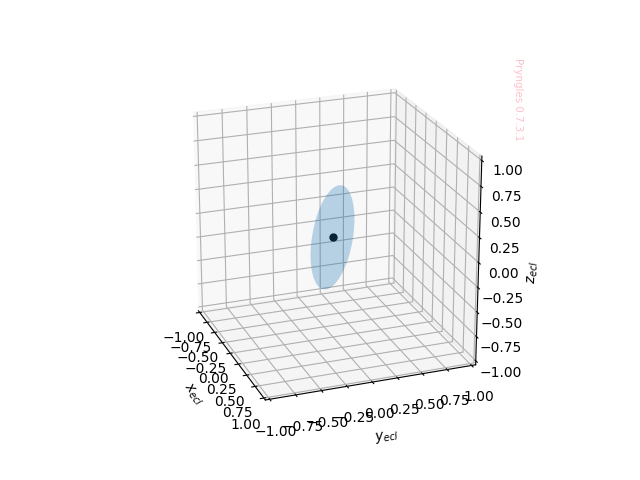

(0.75, 0.475, 0.25)


<IPython.core.display.Javascript object>


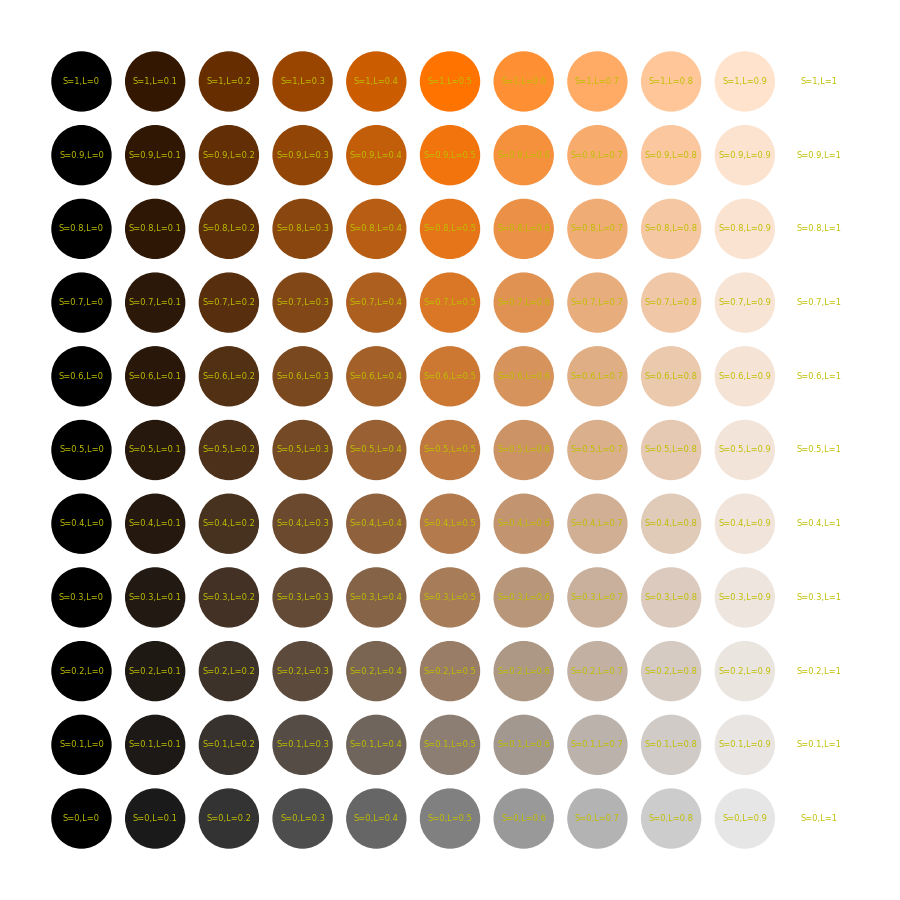

.
----------------------------------------------------------------------
Ran 1 test in 0.143s

OK


In [4]:
if IN_JUPYTER:
    def test_fun(self):
        fig=plt.figure()
        ax=fig.add_subplot(111,projection='3d')
        ax.plot([0],[0],[0],'ko',markersize=5)
        Plot.circle3d(ax,(0,0,0),0.5,zDir=[1,1,0],fill='None',alpha=0.3)
        #Decoration
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)
        ax.set_box_aspect([1,1,1])
        ax.set_xlabel("$x_{ecl}$")
        ax.set_ylabel("$y_{ecl}$")
        ax.set_zlabel("$z_{ecl}$")
        ax.view_init(elev=15,azim=1)
        Plot.pryngles_mark(ax)
        
        #rgb
        print(Plot.rgb([27,0.5,0.5]))
        
        #Color sample
        Plot.rgb_sample(27)
        
    class Test(unittest.TestCase):pass
    Test.test_fun=test_fun
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Flybys

In [6]:
def calc_flyby(normal=[0,0,1],start=0,stop=360,num=10,lat=0):
    
    """Calculate a flyby coordinates
    
    Parameters:
        normal: array (3), default = [0,0,1]:
            Normal to flyby plane.
            
        start: float, default = 0:
            Start longitude.
            
        stop: float, default = 0:
            Stop longitude.
            
        num: int, default = 10:
            Number of points in flyby.
            
        lat: float, default = 0:
            Constant latitude of flyby.
    """

    #Range of longitudes and latitudes
    lonp=np.linspace(start,stop,num)
    latp=lat*np.ones_like(lonp)
    
    #Rotation matrices
    M,I=Science.rotation_matrix(normal,0)

    #Compute directions
    nvecs=np.zeros((num,3))
    for i in range(num):
        rp=Science.direction(lonp[i],latp[i])
        nvecs[i]=spy.mxv(I,rp)

    return nvecs

Plot.calc_flyby=calc_flyby

<IPython.core.display.Javascript object>


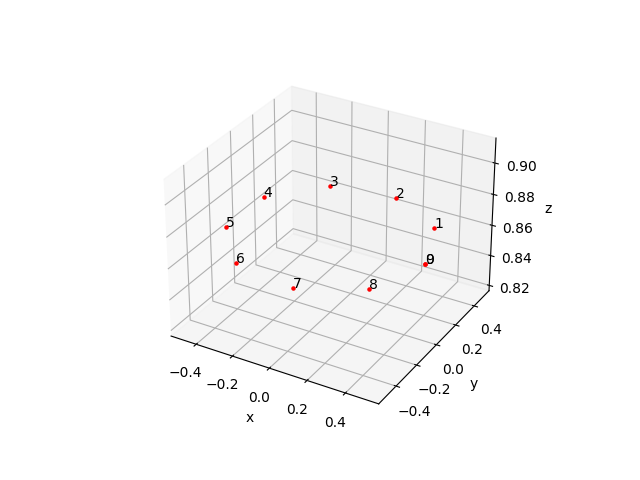

.
----------------------------------------------------------------------
Ran 1 test in 0.043s

OK


In [7]:
if IN_JUPYTER:
    def test_flyby(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        nvecs=Plot.calc_flyby(normal=[0,0,1],lat=60)

        fig=plt.figure()
        ax=fig.add_subplot(111,projection='3d')

        for i in range(len(nvecs)):
            ax.scatter(nvecs[i,0],nvecs[i,1],nvecs[i,2],c='r',s=5)
            ax.text(nvecs[i,0],nvecs[i,1],nvecs[i,2],i)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_flyby=test_flyby
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Animate rebound

In [8]:
def animate_rebound(sim,filename=None,tini=0,tend=2*np.pi,nsnap=10,interval=100):

    verbosity=Verbose.VERBOSITY
    Verbose.VERBOSITY=VERB_NONE
    
    fig,ax=plt.subplots()

    camera=Camera(fig)

    for t in tqdm(np.linspace(tini,tend,nsnap)):
        sim.integrate(t)
        sim.move_to_com()
        
        for p in sim.particles:
            xyz=p.xyz
            ax.plot(xyz[0],xyz[1],marker='o',color='r')
        
        camera.snap()
    
    ax.axis("equal")
    ax.grid()
    
    anim=camera.animate(interval=interval)
    
    Verbose.VERBOSITY=verbosity
    
    if filename is not None:
        if 'gif' in filename:
            anim.save(filename)
            return anim
        elif 'mp4' in filename:
            ffmpeg=animation.writers["ffmpeg"]
            metadata = dict(title='Pryngles Spangler Animation',
                            artist='Matplotlib',
                            comment='Movie')
            w=ffmpeg(fps=15,metadata=metadata)
            anim.save(filename,w)
            return anim
        else:
            raise ValueError(f"Animation format '{filename}' not recognized")
    else:
        return anim

    
    return anim

Plot.animate_rebound=animate_rebound

<IPython.core.display.Javascript object>


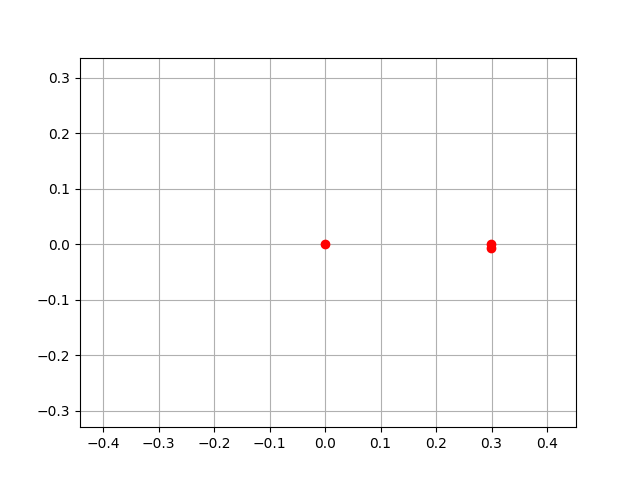

100%|██████████| 5/5 [00:00<00:00, 508.89it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.339s

OK


In [9]:
if IN_JUPYTER:
    def test_animrb(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        sim=rb.Simulation()
        ms=1
        sim.add(m=1)
        mp=1e-3
        xp=0.3
        vp=np.sqrt(sim.G*ms/xp)
        sim.add(m=mp,x=xp,vy=vp)
        mm=1e-8
        xm=0.01
        vm=np.sqrt(sim.G*mp/xm)
        sim.add(m=mm,x=xp+xm,vy=vp+vm)
        P=sim.particles[1].P

        anim=Plot.animate_rebound(sim,filename="/tmp/animate-rebound.gif",tend=P,nsnap=5,interval=20)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_animrb=test_animrb
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--